# Student Performance Dataset - Goal 3

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from sklearn.preprocessing import PolynomialFeatures, \
    MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, \
    f_regression, RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from models import TrivialSystem
from transforms import BinaryEncoder, RemoveFeatures, \
    IdentityTransform
np.random.seed(43)

In [4]:
NUM_FEATURES_TO_SELECT = 10
PLOTS_FOLDER = "plots/goal3"

In [5]:
# List to store the names of the features
feature_names = ["school", "sex", "age", "address", "famsize", "Pstatus",
                 "Medu", "Fedu", "Mjob", "Fjob", "reason", "guardian",
                 "traveltime", "studytime", "failures", "schoolsup", "famsup",
                 "paid", "activities", "nursery", "higher", "internet", "romantic",
                 "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences",
                 "G1", "G2",]

feature_names = np.array(feature_names)

In [6]:
datapoints, labels, feature_info, categories = utils.read_data(
    "datasets/student_performance_train.csv",
    "datasets/student_performance_feature.txt")
test_data, test_labels, _, _ = utils.read_data(
    "datasets/student_performance_test.csv",
    "datasets/student_performance_feature.txt")

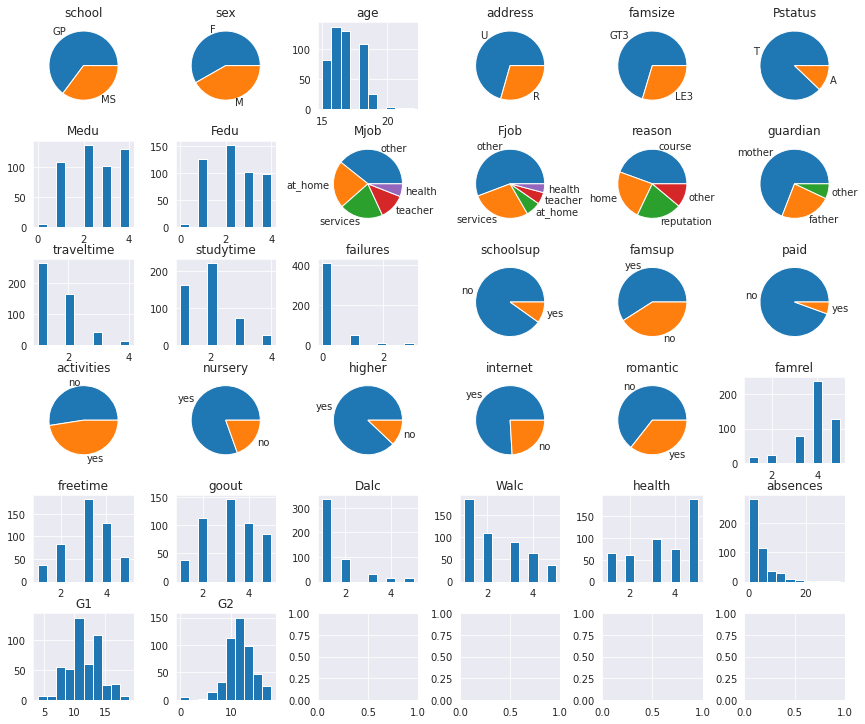

In [7]:
# Add the first two academic performances as features to the dataset
datapoints = np.append(datapoints, labels[:, :2], axis=1)
test_data = np.append(test_data, test_labels[:, :2], axis=1)

# Update feature info
feature_info = np.append(feature_info, ["numeric", "numeric"])

num_features = datapoints.shape[1]

fig, _ = plt.subplots(num_features//6 + 1, 6)
fig.set_size_inches(12, 10)
fig.tight_layout()

for i in range(num_features):
    if feature_info[i] in ["nominal", "binary"]:
        plt.sca(fig.axes[i])
        pd.Series(datapoints[:, i]).value_counts().plot.pie()
        fig.axes[i].axis('off')
    else:
        fig.axes[i].hist(datapoints[:, i])
    fig.axes[i].set_title(feature_names[i])

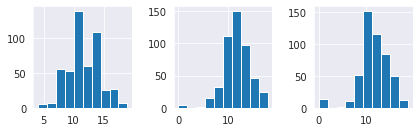

In [8]:
num_targets = labels.shape[1]

fig, _ = plt.subplots(1, 3)
fig.set_size_inches(6, 2)
fig.tight_layout()

for i in range(num_targets):
    fig.axes[i].hist(labels[:, i])
plt.show()

In [9]:
# Define a column transformer to
# 1) Encode binary features
# 2) Remove categorical features
# 3) The FunctionTransformer() is just for retaining numeric features as is

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("RemoveNominal", RemoveFeatures(),
     np.where(feature_info == "nominal")[0]),
])

## Trivial Regressor - Goal 3

0.0
Root Mean Square Error: 3.174805068678614
Mean Absolute Error: 2.4686561135095553
R-Squared score: -0.0002660878104270292


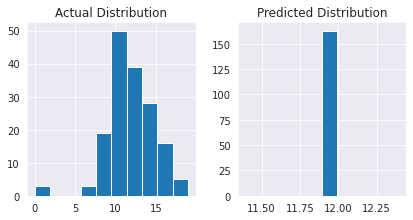

In [10]:
pipe = Pipeline([
    ("Preprocessor", ct),
    ("TrivialRegressor", TrivialSystem())
])

pipe.fit(datapoints, labels[:, 2])
print(pipe.score(datapoints, labels[:, 2]))
y_pred = pipe.predict(test_data)
utils.report_metrics(test_labels[:, 2], y_pred)
plt.savefig(f"{PLOTS_FOLDER}/trivial_reg.png")

## 1NN - Goal 3

1.0
Root Mean Square Error: 1.568477828783851
Mean Absolute Error: 1.0736196319018405
R-Squared score: 0.7558604255064842


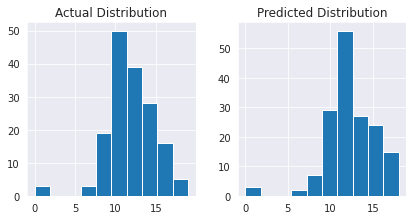

In [11]:
pipe = Pipeline([
    ("Preprocessor", ct),
    ("KNNRegression", KNeighborsRegressor(n_neighbors=1)),
])

pipe.fit(datapoints, labels[:, 2])
print(pipe.score(datapoints, labels[:, 2]))
y_pred = pipe.predict(test_data)
utils.report_metrics(test_labels[:, 2], y_pred)
plt.savefig(f"{PLOTS_FOLDER}/1nn_reg.png")

## Linear Regression - Goal 3

0.8399354495227023
Root Mean Square Error: 1.013586565921694
Mean Absolute Error: 0.7168448641204608
R-Squared score: 0.8980462729393814


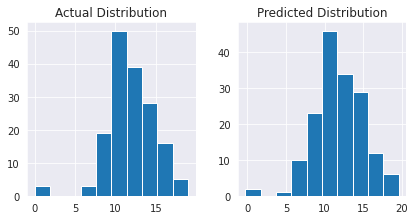

In [12]:
pipe = Pipeline([
    ("Preprocessor", ct),
    ("LinearRegression", LinearRegression()),
])

pipe.fit(datapoints, labels[:, 2])
with np.printoptions(precision=2, suppress=True):
    print(pipe.score(datapoints, labels[:, 2]))
y_pred = pipe.predict(test_data)
utils.report_metrics(test_labels[:, 2], y_pred)
plt.savefig(f"{PLOTS_FOLDER}/linear_reg.png")

## Feature Engineering

In [13]:
ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0])
])

ct.fit(datapoints)
datapoints_pp = ct.transform(datapoints)
datapoints_pp.shape

(486, 45)

<AxesSubplot:>

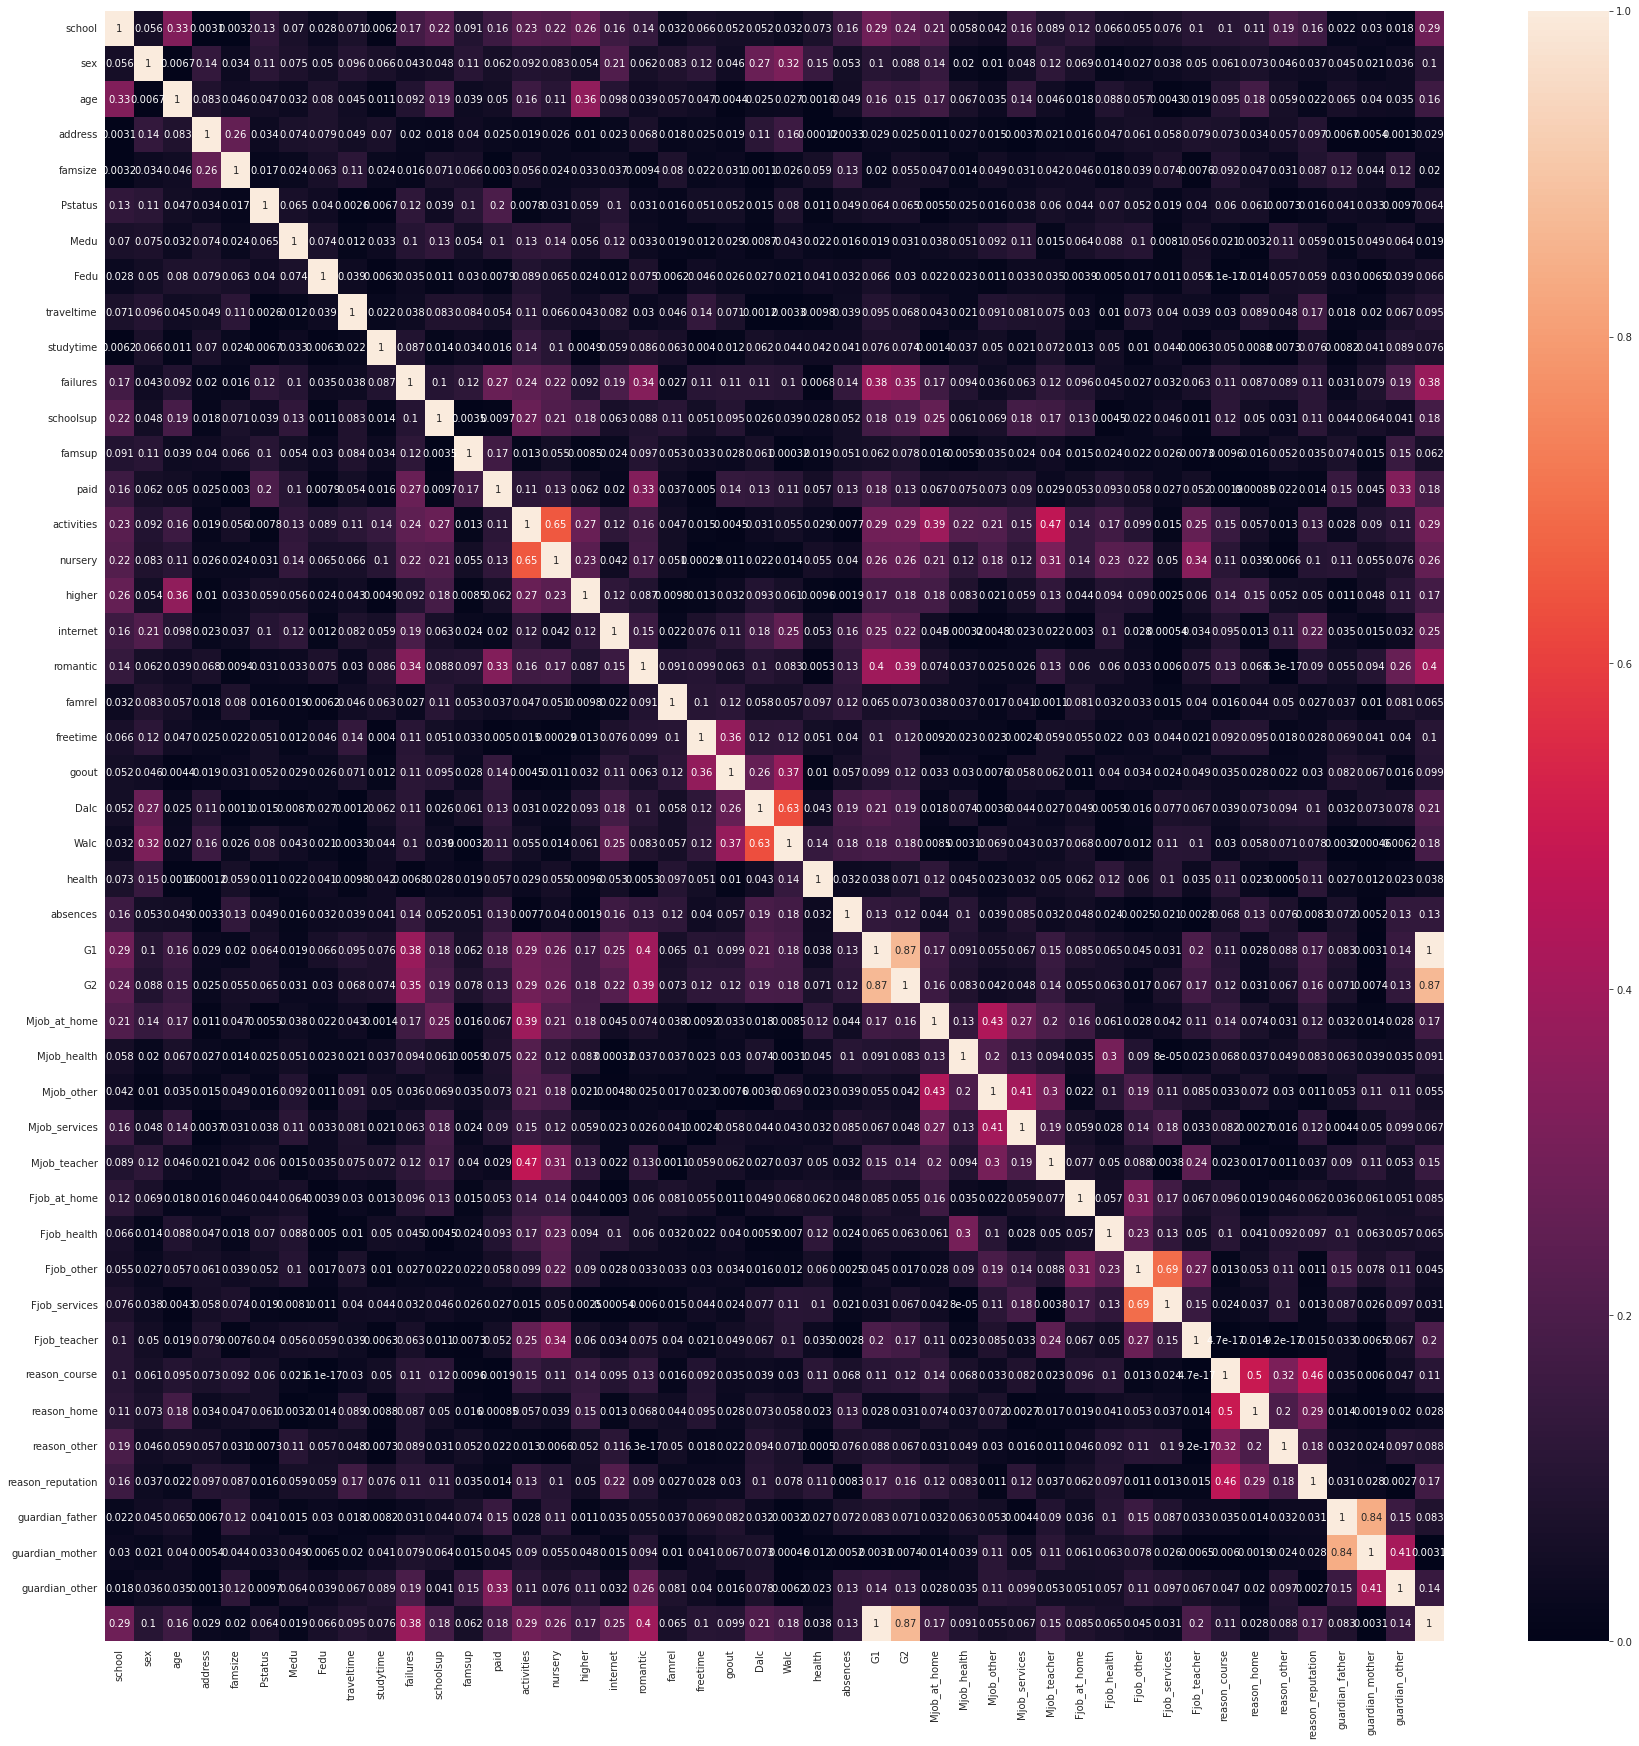

In [14]:
# Create a figure
fig = plt.figure()
fig.set_size_inches(30, 30)

# Create an array to store all the data
all_data = np.append(datapoints_pp, labels[:, :1], axis=1)

# Calculate correlation between all the features and the output
# and get the absolute value of the correlation
corr = np.corrcoef(all_data.astype(float), rowvar=False)
p_corr = abs(corr)

axis_names = np.append(feature_names[feature_info != "nominal"],
                       ct.transformers_[2][1].get_feature_names(
                           feature_names[feature_info == "nominal"]))

# Plot a heatmap of the correlation
sns.heatmap(p_corr, annot=p_corr,
            xticklabels=axis_names,
            yticklabels=axis_names,
            )

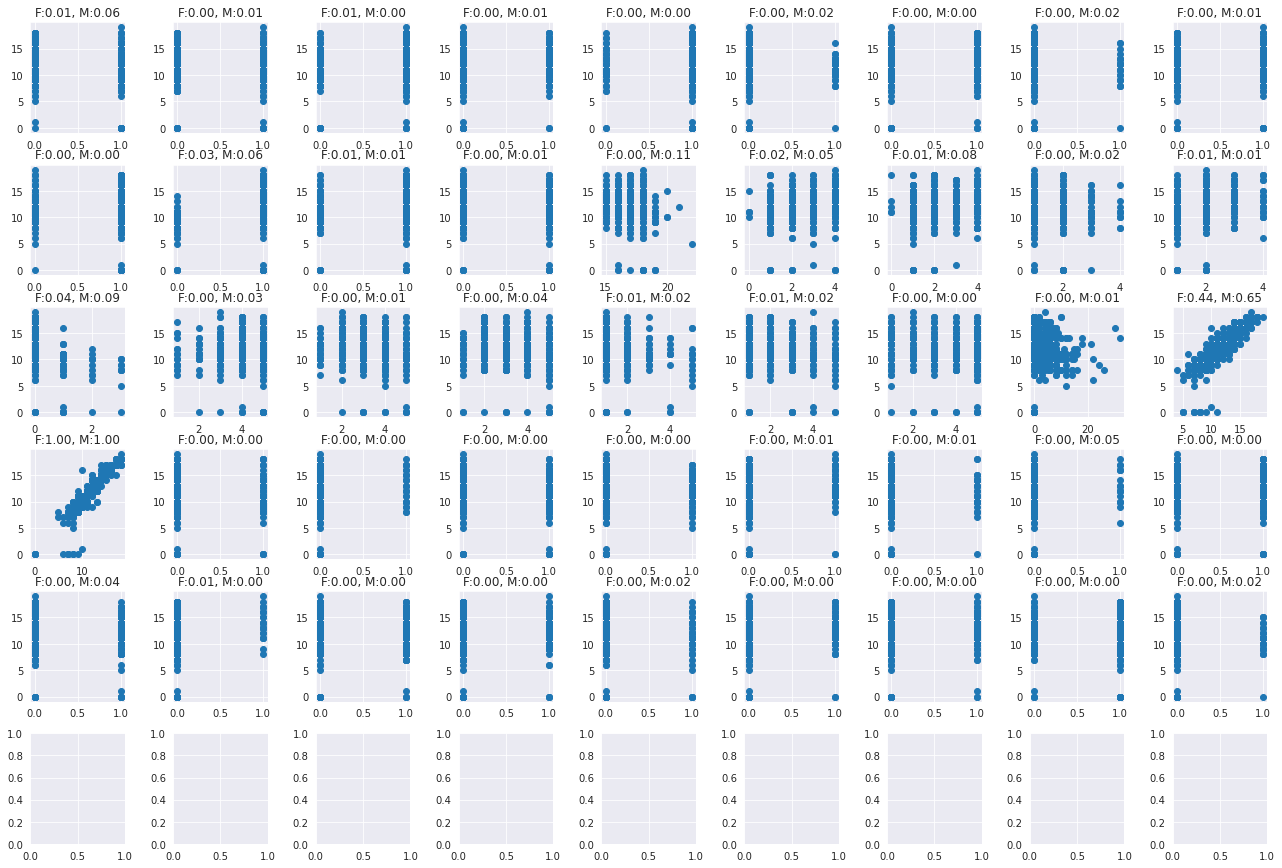

In [15]:
# Plot each feature with the output with f_regression score and mutual information score
_ = utils.get_information_plots(datapoints_pp, labels[:, 2])

In [16]:
# Top 10 features with the highest correlation with the output
top_corr_features = np.argsort(p_corr[:-1, -1])[::-1]
print(axis_names[top_corr_features][:NUM_FEATURES_TO_SELECT])
print(sorted(top_corr_features[:NUM_FEATURES_TO_SELECT]))

['G1' 'G2' 'romantic' 'failures' 'activities' 'school' 'nursery'
 'internet' 'Dalc' 'Fjob_teacher']
[0, 10, 14, 15, 17, 18, 22, 26, 27, 37]


In [17]:
# Select features based on f_regression score
skb_f = SelectKBest(score_func=f_regression, k=NUM_FEATURES_TO_SELECT)
skb_f.fit(datapoints_pp, labels[:, 2])
print(axis_names[skb_f.get_support(indices=True)])
print(skb_f.get_support(indices=True))

['school' 'failures' 'activities' 'nursery' 'internet' 'romantic' 'Dalc'
 'Walc' 'G1' 'G2']
[ 0 10 14 15 17 18 22 23 26 27]


In [18]:
# Select features based on f_regression score
skb_m = SelectKBest(score_func=utils.mutual_info_regression_seeded, k=NUM_FEATURES_TO_SELECT)
skb_m.fit(datapoints_pp, labels[:, 2])
print(axis_names[skb_m.get_support(indices=True)])
print(skb_m.get_support(indices=True))

['school' 'failures' 'paid' 'activities' 'nursery' 'romantic' 'G1' 'G2'
 'Fjob_health' 'Fjob_services']
[ 0 10 13 14 15 18 26 27 34 36]


In [19]:
# RFECV using LinearRegression
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5, min_features_to_select=NUM_FEATURES_TO_SELECT)
selector.fit(datapoints_pp, labels[:, 2])
print(axis_names[selector.get_support(indices=True)])
print(selector.get_support(indices=True))

['sex' 'Pstatus' 'Fedu' 'studytime' 'failures' 'romantic' 'G2'
 'Fjob_at_home' 'reason_other' 'guardian_other']
[ 1  5  7  9 10 18 27 33 40 44]


### Cross Validation to determine the number of features to select

100%|██████████| 28/28 [00:02<00:00, 12.43it/s]


5 [0.93070537 0.81766426 0.76071806 0.79481856 0.82691305]
Root Mean Square Error: 0.9455815857944397
Mean Absolute Error: 0.7087556247619324
R-Squared score: 0.9112681722461953


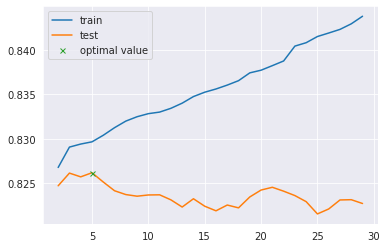

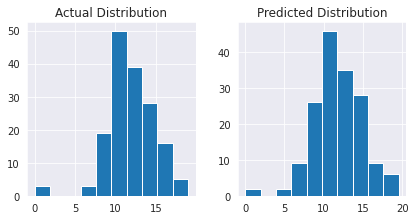

In [20]:
search_space = range(2, 30, 1)

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = lambda k: Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression, k=k)),
    ("LinearRegression", LinearRegression()),
])

ms = utils.ModelSelector(pipeline=pipe)
cv_output, k, fig = ms.fit(datapoints, labels[:, 2], search_space)
print(k, cv_output["test_score"])
y_pred = ms.get_best_estimator().predict(test_data)
utils.report_metrics(test_labels[:, 2], y_pred)
fig.savefig(f"{PLOTS_FOLDER}/cv_feature_select.png")

### Cross Validation to determine the optimal number of neighbors for KNN Regression

100%|██████████| 28/28 [00:03<00:00,  8.09it/s]


10 [0.92271584 0.82981498 0.73153112 0.76030387 0.77836165]
[ 27  42  57 161 162]
Root Mean Square Error: 1.1178419173332335
Mean Absolute Error: 0.8061349693251533
R-Squared score: 0.8759941433096277


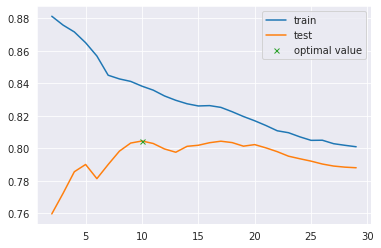

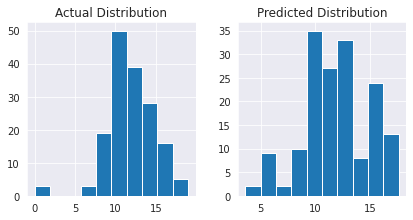

In [21]:
search_space = range(2, 30, 1)

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("RemoveNominal", RemoveFeatures(),
     np.where(feature_info == "nominal")[0]),
    ("Poly",
     PolynomialFeatures(include_bias=False, interaction_only=False),
     np.where(feature_info == "numeric")[0])
])

pipe = lambda k: Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression, k=5)),
    ("MinMax", MinMaxScaler()),
    ("KNN", KNeighborsRegressor(n_neighbors=k, weights="uniform")),
])

ms = utils.ModelSelector(pipeline=pipe)
cv_output, k, fig = ms.fit(datapoints, labels[:, 2], search_space)
fig.savefig(f"{PLOTS_FOLDER}/knn_reg_cv.png")
print(k, cv_output["test_score"])
print(ms.get_best_estimator()[1].get_support(indices=True))
y_pred = ms.get_best_estimator().predict(test_data)
utils.report_metrics(test_labels[:, 2], y_pred)
plt.savefig(f"{PLOTS_FOLDER}/knn_reg.png")

### Cross Validation to determine C - The regularization parameter in SVR

100%|██████████| 36/36 [00:06<00:00,  5.76it/s]


13.0 [0.94343724 0.81432416 0.75844755 0.77239052 0.8283126 ]
Root Mean Square Error: 0.9484454074077264
Mean Absolute Error: 0.6924909821822295
R-Squared score: 0.9107298856797313


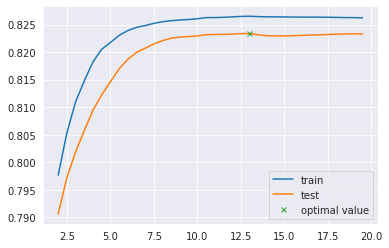

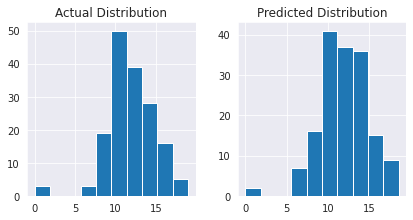

In [22]:
search_space = np.arange(2, 20, 0.5)

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = lambda k: Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression, k=5)),
    ("SVR", SVR(C=k, kernel="rbf")),
])

ms = utils.ModelSelector(pipeline=pipe)
cv_output, k, fig = ms.fit(datapoints, labels[:, 2], search_space)
fig.savefig(f"{PLOTS_FOLDER}/cv_svr.png")
print(k, cv_output["test_score"])
y_pred = ms.get_best_estimator().predict(test_data)
utils.report_metrics(test_labels[:, 2], y_pred)
plt.savefig(f"{PLOTS_FOLDER}/svr_1.png")

In [23]:
ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression, k=5)),
    ("SVR", SVR()),
])

parameters = {"SVR__C":np.arange(10, 20, 0.5),
              "SVR__epsilon":[0.01, 0.1],
              "SVR__kernel":["rbf", "linear", "poly"]}
gs = GridSearchCV(pipe, parameters, refit=True)
gs.fit(datapoints, labels[:, 2])

GridSearchCV(estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('BinaryEncoder',
                                                                         BinaryEncoder(),
                                                                         array([ 0,  1,  3,  4,  5, 15, 16, 17, 18, 19, 20, 21, 22])),
                                                                        ('Identity',
                                                                         IdentityTransform(),
                                                                         array([ 2,  6,  7, 12, 13, 14, 23, 24, 25, 26, 27, 28, 29, 30, 31])),
                                                                        ('OneHotEncoder',
                                                                         OneHotEncoder(),
                                                                         array([ 8,  9, 10, 11]))])),
                         

Best parameters for SVR grid search {'SVR__C': 13.0, 'SVR__epsilon': 0.1, 'SVR__kernel': 'rbf'}
Root Mean Square Error: 0.9493946574652442
Mean Absolute Error: 0.6911084546685609
R-Squared score: 0.9105511045579766


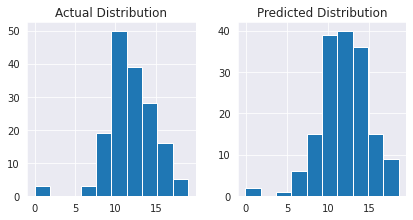

In [24]:
print("Best parameters for SVR grid search", gs.best_params_)
y_pred = gs.best_estimator_.predict(test_data)
utils.report_metrics(test_labels[:, 2], y_pred)
plt.savefig(f"{PLOTS_FOLDER}/svr_2.png")

### Cross Validation to find the number of hidden neurons in an MLP

100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


50 [0.93260851 0.81825735 0.76499074 0.7957565  0.83226929]
Root Mean Square Error: 0.9700483399009561
Mean Absolute Error: 0.7219957388299684
R-Squared score: 0.906616925434873


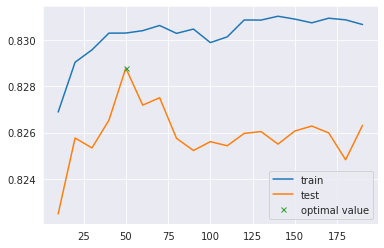

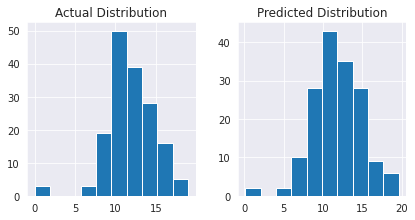

In [25]:
search_space = np.arange(10, 200, 10)

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = lambda k: Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression, k=5)),
    ("MLP", MLPRegressor(hidden_layer_sizes=(k, ),
                         solver="sgd")),
])

ms = utils.ModelSelector(pipeline=pipe)
cv_output, k, fig = ms.fit(datapoints, labels[:, 2], search_space)
print(k, cv_output["test_score"])
fig.savefig(f"{PLOTS_FOLDER}/ann_cv.png")
y_pred = ms.get_best_estimator().predict(test_data)
utils.report_metrics(test_labels[:, 2], y_pred)
plt.savefig(f"{PLOTS_FOLDER}/ann_reg.png")

### Cross Validation to determine alpha value in Ridge Regression

100%|██████████| 116/116 [00:08<00:00, 13.26it/s]


35.0 [0.93209406 0.81605755 0.76390071 0.79211526 0.82931979]
Root Mean Square Error: 0.9409117405633599
Mean Absolute Error: 0.7007652457487548
R-Squared score: 0.9121424293615616


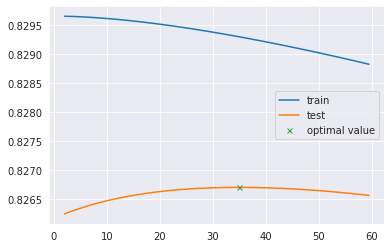

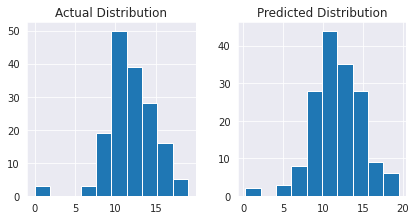

In [26]:
search_space = np.arange(2, 60, 0.5)

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = lambda k: Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression, k=5)),
    ("Ridge", Ridge(alpha=k))
])

ms = utils.ModelSelector(pipeline=pipe)
cv_output, k, fig = ms.fit(datapoints, labels[:, 2], search_space)
print(k, cv_output["test_score"])
fig.savefig(f"{PLOTS_FOLDER}/ridge_cv.png")
y_pred = ms.get_best_estimator().predict(test_data)
utils.report_metrics(test_labels[:, 2], y_pred)
plt.savefig(f"{PLOTS_FOLDER}/ridge_reg.png")

In [27]:
search_space = np.arange(2, 60, 0.5)

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression)),
    ("Ridge", Ridge())
])

parameters = {"skb__k":range(2, 30),
              "Ridge__alpha":np.arange(2, 60, 0.5)}

gs = GridSearchCV(pipe, parameters, refit=True)
gs.fit(datapoints, labels[:, 2])

GridSearchCV(estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('BinaryEncoder',
                                                                         BinaryEncoder(),
                                                                         array([ 0,  1,  3,  4,  5, 15, 16, 17, 18, 19, 20, 21, 22])),
                                                                        ('Identity',
                                                                         IdentityTransform(),
                                                                         array([ 2,  6,  7, 12, 13, 14, 23, 24, 25, 26, 27, 28, 29, 30, 31])),
                                                                        ('OneHotEncoder',
                                                                         OneHotEncoder(),
                                                                         array([ 8,  9, 10, 11]))])),
                         

In [28]:
gs.best_params_

{'Ridge__alpha': 59.5, 'skb__k': 29}

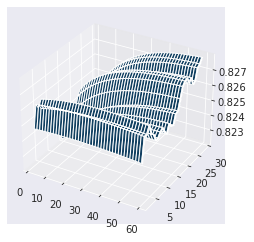

In [29]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(gs.cv_results_["param_Ridge__alpha"].reshape(116, 28),
                gs.cv_results_["param_skb__k"].reshape(116, 28),
                gs.cv_results_["mean_test_score"].reshape(116, 28))
plt.savefig(f"{PLOTS_FOLDER}/ridge_reg_gs.png")

Root Mean Square Error: 0.9540129528772765
Mean Absolute Error: 0.6905300212160973
R-Squared score: 0.909678746200955


(0.9540129528772765,
 0.6905300212160973,
 0.909678746200955,
 <Figure size 432x216 with 2 Axes>)

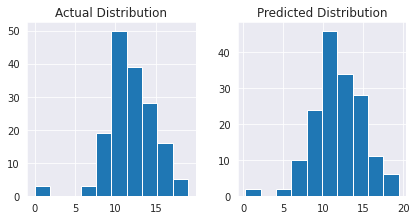

In [30]:
utils.report_metrics(test_labels[:, 2], gs.best_estimator_.predict(test_data))